# Elastic Search REST Queries

In [3]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

## Docker ES

In [5]:
es_url1 = 'http://es-test:9200/{0}'
es_resource1 = 'landgrid/_search'

headers = {
            'Content-Type': 'application/json',
            'Cache-Control': 'no-cache'
        }

In [6]:
url = es_url1.format(es_resource1)
payload = {
  "aggregations" : {
      "no county" : {
          "missing" : { 
            "field" : "Abstract" 
          },
          "aggregations": {
            "by_state": {
              "terms": {
                "field": "State",
                "size": 100,
                "order" : { "_key" : "asc" }
              },
              "aggregations": {
                "by_type": {
                  "terms": {
                    "field": "Type",
                    "size": 100,
                    "order" : { "_key" : "asc" }
                  }
                }
              }
            }
          }
      }
  },
  "size": 0
}

r = requests.get(url, headers=headers, json=payload)
print(r.encoding)
result = r.json()

UTF-8


In [16]:
total = result['aggregations']['no county']['doc_count']

buckets = result['aggregations']['no county']['by_state']['buckets']

In [17]:
buckets

[{'key': 'AZ',
  'doc_count': 3,
  'by_type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'Type 1', 'doc_count': 1},
    {'key': 'Type 2', 'doc_count': 1},
    {'key': 'Type 3', 'doc_count': 1}]}},
 {'key': 'NM',
  'doc_count': 4,
  'by_type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'Type 1', 'doc_count': 1},
    {'key': 'Type 2', 'doc_count': 1},
    {'key': 'Type 3', 'doc_count': 2}]}}]

In [42]:
by_state_df1 = pd.DataFrame(buckets)
by_state_df1["buckets"] = by_state_df1.by_type.apply(lambda x: x['buckets'])
by_state_df1["keyval"] = by_state_df1.buckets.apply(lambda x: {d['key']:d['doc_count'] for d in x})

tmp_df = pd.DataFrame(by_state_df1["keyval"].to_dict())
tmp_df = tmp_df.transpose().copy()

shredded_df = by_state_df1.join(tmp_df)
shredded_df.drop(columns=["by_type", "buckets", "keyval"], inplace=True, axis=1)
shredded_df.set_index('key', inplace=True)
shredded_df

,doc_count,Type 1,Type 2,Type 3
key,,,,
AZ,3,1,1,1
NM,4,1,1,2


Text(0.5, 0, 'State')

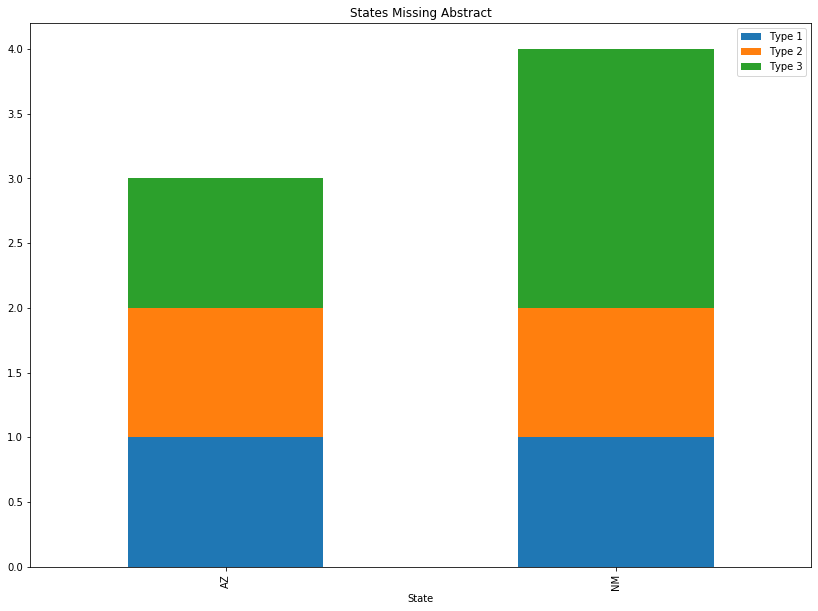

In [50]:
shredded_df.iloc[:, 1:].plot.bar(title="States Missing Abstract", stacked=True, figsize=(14, 10))
plt.xlabel('State')

## DI Direct

In [6]:
# Master node IP
es_url2 = 'http://##.###.#.###:9200/{0}'
es_resource2 = 'landgrid_07182018/landgrid/_search'

headers = {
            'Content-Type': 'application/json',
            'Cache-Control': 'no-cache'
        }

In [7]:
url = es_url2.format(es_resource2)
payload = {
  "query": {
    "match_all": {
    }
  },
  "aggregations": {
    "by_state": {
      "terms": {
        "field": "State",
        "size": 100,
        "order" : { "_key" : "asc" }
      },
      "aggregations": {
        "by_type": {
          "terms": {
            "field": "Type",
            "size": 100,
            "order" : { "_key" : "asc" }
          }
        }
      }
    }
  },
  "size": 0
}

r = requests.get(url, headers=headers, json=payload)
print(r.encoding)
result = r.json()

UTF-8


In [8]:
result['aggregations']['by_state']['buckets'][:2]

[{'key': 'AK',
  'doc_count': 30,
  'by_type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'County', 'doc_count': 29},
    {'key': 'State', 'doc_count': 1}]}},
 {'key': 'AL',
  'doc_count': 50878,
  'by_type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'County', 'doc_count': 67},
    {'key': 'Section', 'doc_count': 49288},
    {'key': 'State', 'doc_count': 1},
    {'key': 'Township', 'doc_count': 1522}]}}]

In [20]:
by_state = result['aggregations']['by_state']['buckets']

In [25]:
by_state_df2 = pd.DataFrame(by_state)
by_state_df2["buckets"] = by_state_df2.by_type.apply(lambda x: x['buckets'])
by_state_df2["keyval"] = by_state_df2.buckets.apply(lambda x: {d['key']:d['doc_count'] for d in x})

tmp_df = pd.DataFrame(by_state_df2["keyval"].to_dict())
tmp_df = tmp_df.transpose().copy()

shredded_df = by_state_df2.join(tmp_df)
shredded_df.drop(columns=["by_type", "buckets", "keyval"], inplace=True, axis=1)
shredded_df.set_index('key', inplace=True)
shredded_df.head()

,doc_count,County,State,Section,Township,Abstract,Block
key,,,,,,,
AK,30,29.0,1.0,NaN,NaN,NaN,NaN
AL,50878,67.0,1.0,49288.0,1522.0,NaN,NaN
AR,56430,75.0,1.0,54592.0,1694.0,68.0,NaN
AZ,101527,15.0,1.0,98395.0,3116.0,NaN,NaN
CA,166052,58.0,1.0,161062.0,4931.0,NaN,NaN


In [28]:
shredded_df.to_csv('states_by_landgrid_type.csv')

Text(0.5, 0, 'State')

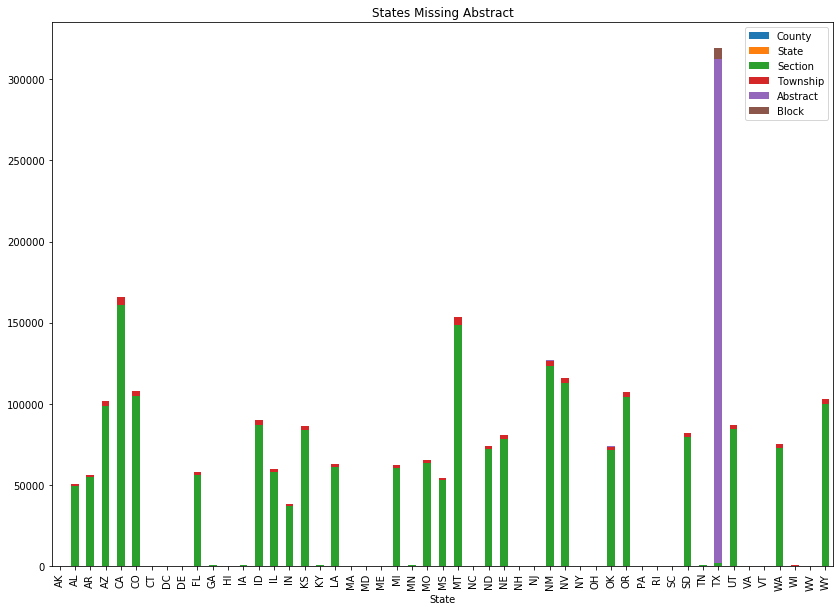

In [23]:
shredded_df.iloc[:, 1:].plot.bar(title="States Missing Abstract", stacked=True, figsize=(14, 10))
plt.xlabel('State')

## DI via Consul DNS

In [ ]:
es_url3 = 'http://xxx.xx.xx:9200/{0}'
es_resource3 = 'landgrid/_search'
url = es_url3.format(es_resource3)

payload = {
  "query": {
    "match_all": {
    }
  },
  "aggregations": {
    "by_state": {
      "terms": {
        "field": "State",
        "size": 100,
        "order" : { "_key" : "asc" }
      },
      "aggregations": {
        "by_type": {
          "terms": {
            "field": "Type",
            "size": 100,
            "order" : { "_key" : "asc" }
          }
        }
      }
    }
  },
  "size": 0
}

headers = {
            'Content-Type': 'application/json',
            'X-API-KEY': 'yeah I know',
            'Cache-Control': 'no-cache'
        }

# Need to change DNS in Docker
sess = requests.Session()
sess.headers.update(headers)

req = requests.Request('GET', url, params=None, headers=headers, json=payload)

prepped_request = sess.prepare_request(req)

r = sess.send(
    prepped_request,
    stream=False,
    verify=False,
    proxies={},
    cert=None,
    timeout=None,
    allow_redirects=True)

print(r)
print(r.encoding)
result = r.json()
result